<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/02_Flights_to_Day_Array.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Flights Array

The goal of this code is to create an array of shape (days, hours, 100, 100, 20) for training the model later.

**Lists folders containing data**

In [ ]:
import glob

# Home folder
%cd /content/drive/MyDrive/opportunistic-utm

# List of folders with data
folder_list = []
for folder in glob.iglob('dataset/**/**/', recursive=False):
  folder_list.append(folder)

folder_list[:5]

/content/drive/MyDrive/opportunistic-utm


['dataset/2019-01/2019-01-01/',
 'dataset/2019-01/2019-01-02/',
 'dataset/2019-01/2019-01-03/',
 'dataset/2019-01/2019-01-04/',
 'dataset/2019-01/2019-01-05/']

**Creates an array of (# days, 24 hours, 100px, 100px, 20 channels)**

In [ ]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)
  hours_array = np.empty((1,100,100,20))

  for i in range(0, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array[1:])

day_array = np.array(day_array)
day_array.shape

100%|██████████| 273/273 [21:43<00:00,  4.77s/it]


(273, 24, 100, 100, 20)

# Visualization

**Multichannel array flattener**

In [ ]:
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

**Preview single hour**

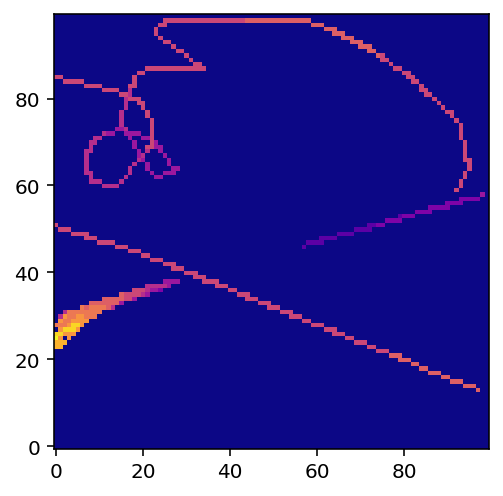

In [ ]:
# Previews single image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

day = 82
hour = 13
flatten = flatten_array(day_array[day, hour])
plt.imshow(flatten, origin='lower', cmap = plt.get_cmap('plasma'))

**Preview full day**

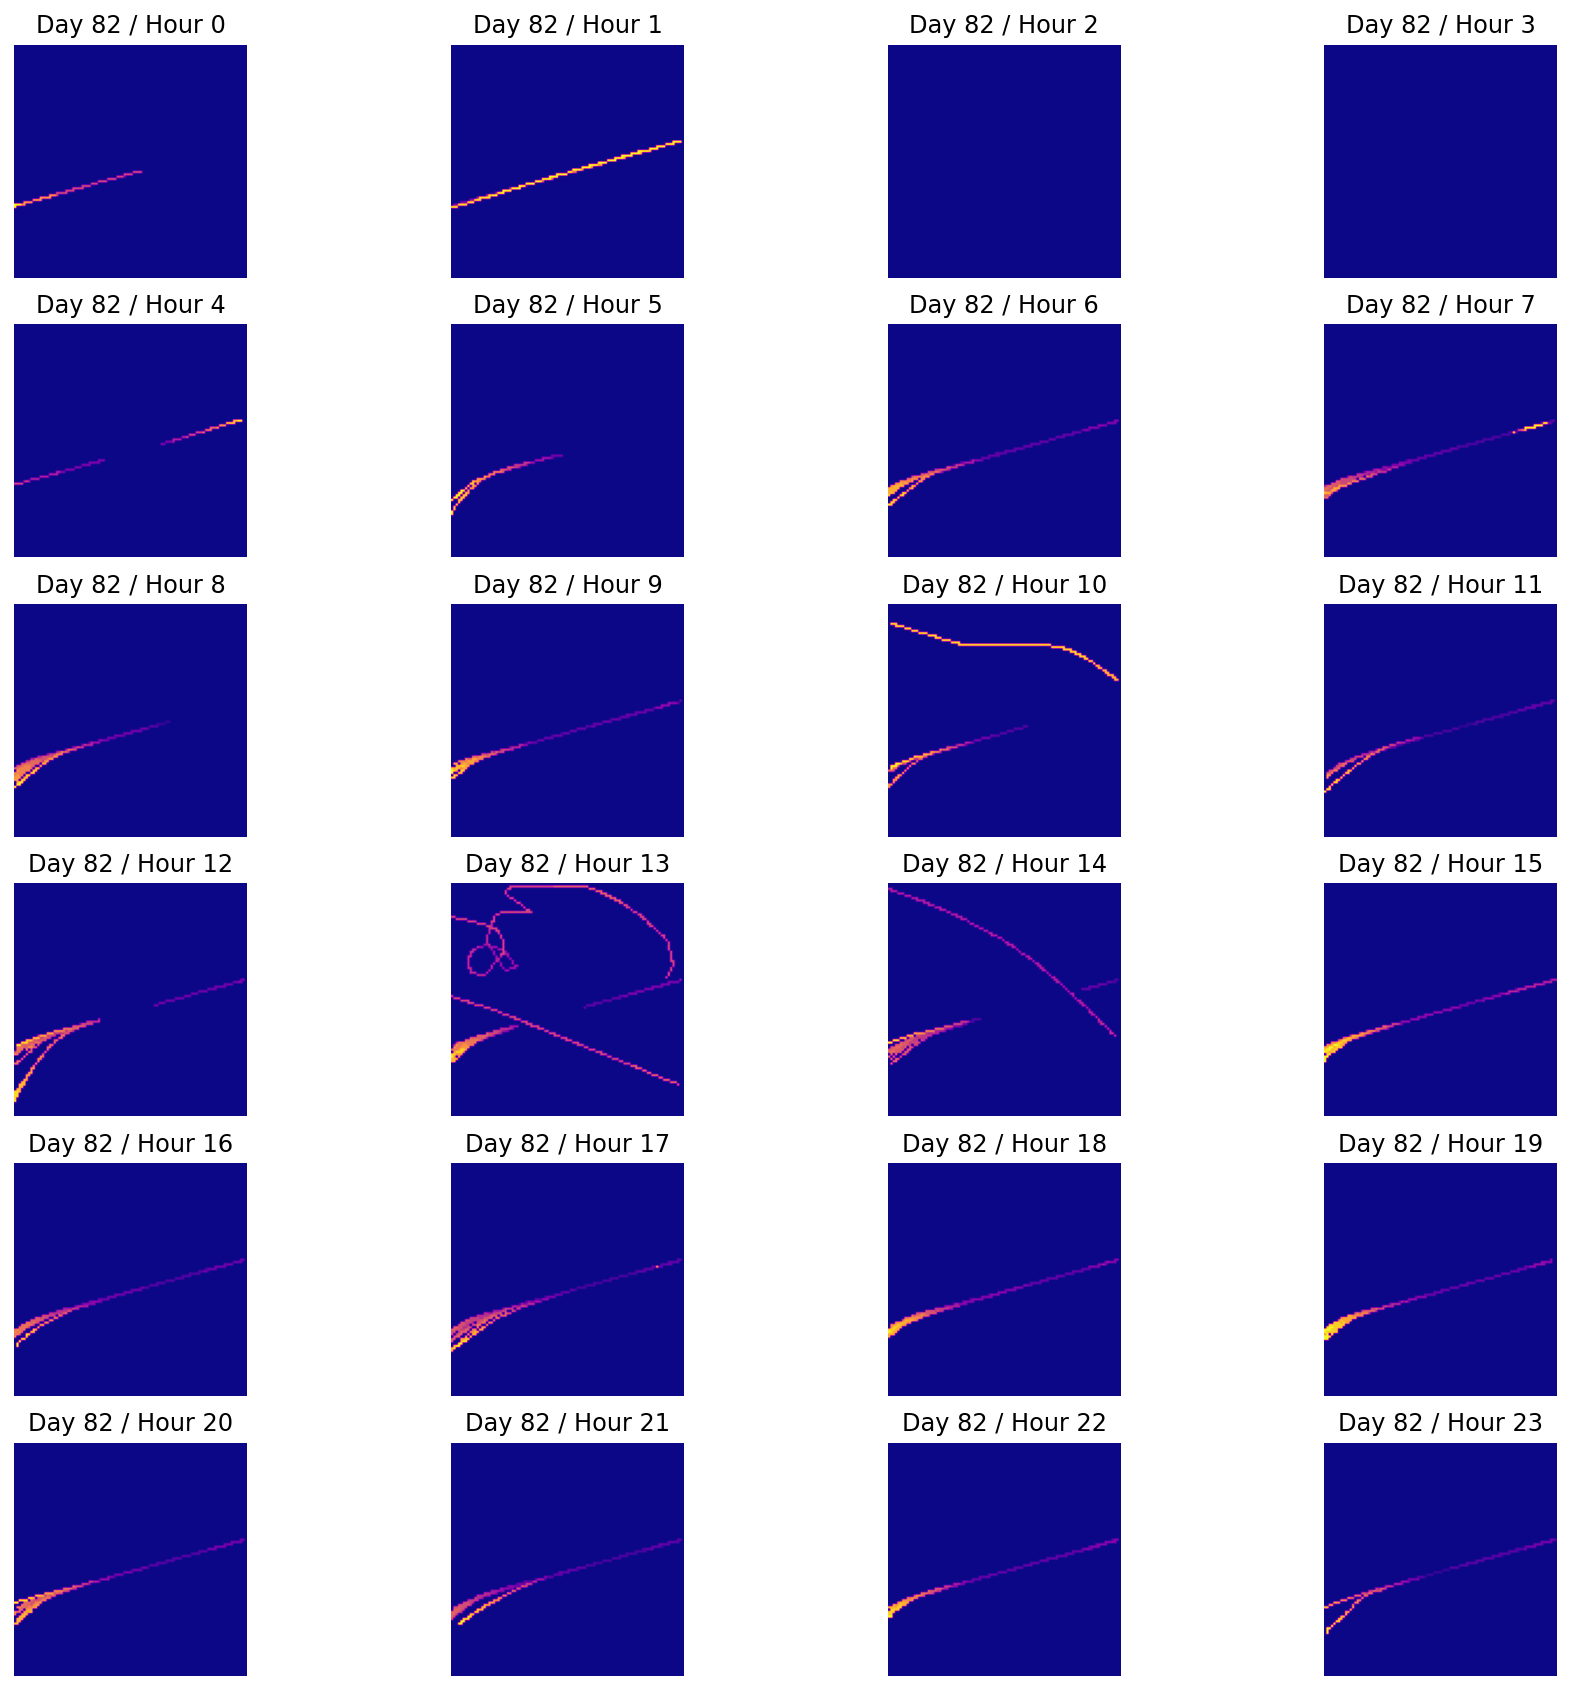

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

day = 82

fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(day_array[day, idx]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'Day {day} / Hour {idx}')
  ax.axis("off")

# Calculate Flights Envelope

**Flights average**

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Level 0: 129
Level 1: 186
Level 2: 164
Level 3: 171
Level 4: 169
Level 5: 192
Level 6: 196
Level 7: 196
Level 8: 194
Level 9: 174
Level 10: 156
Level 11: 104
Level 12: 48
Level 13: 1
Level 14: 0
Level 15: 0
Level 16: 0
Level 17: 0
Level 18: 0
Level 19: 0
Maximum Value: 0.7


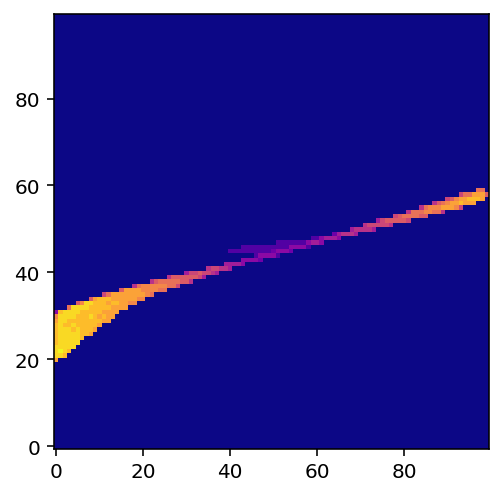

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([day_array.shape[2], day_array.shape[3], day_array.shape[-1]]) # (100, 100, 20)
for channel in tqdm(range(0, day_array.shape[-1])): # iterate channels
  for day in range(0, day_array.shape[0]): # iterate days
    flights_average[:, :, channel] += np.sum(day_array[day, :, :, :, channel], axis=0)

flights_average /= (day_array.shape[0] * day_array.shape[1]) # total_days x total_hours
flights_average = np.where(flights_average > 0.01, 1, 0)

# Show number of pixels by level
for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flights_flatten_average = flatten_array(flights_average)
plt.imshow(flights_flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))
print(f'Maximum Value: {np.max(flights_flatten_average)}')
plt.show()

(100, 100, 20)

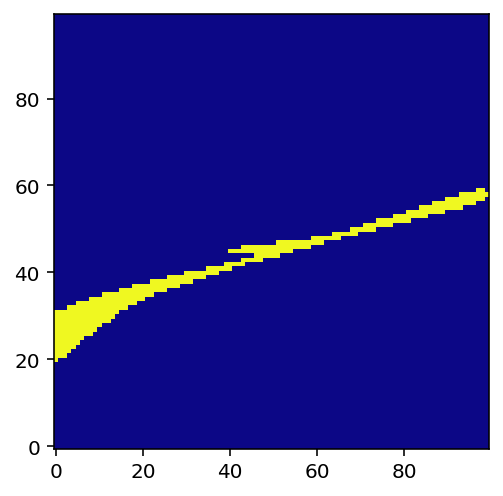

In [ ]:
# Calculates the envelope for all flight levels
flights_envelope = np.where(flights_flatten_average > 0, 1, 0)
stack = []
for i in range(20):
  stack.append(flights_envelope)

flights_envelope = np.array(stack)
flights_envelope = np.moveaxis(flights_envelope, 0, -1)
plt.imshow(flatten_array(flights_envelope), origin='lower', cmap='plasma')
flights_envelope.shape

# Mask Flights Array to Remove Outliers

**Multiply hours by envelope**

In [ ]:
from tqdm import tqdm

# Masks all hours in array
masked_day_array = np.empty((day_array.shape[0], day_array.shape[1], 100, 100, 20))
for i in tqdm(range(day_array.shape[0])):
  for j in range(day_array.shape[1]):
    masked_day_array[i,j] = day_array[i,j] * flights_envelope 

100%|██████████| 273/273 [00:21<00:00, 12.79it/s]


**Preview full day**

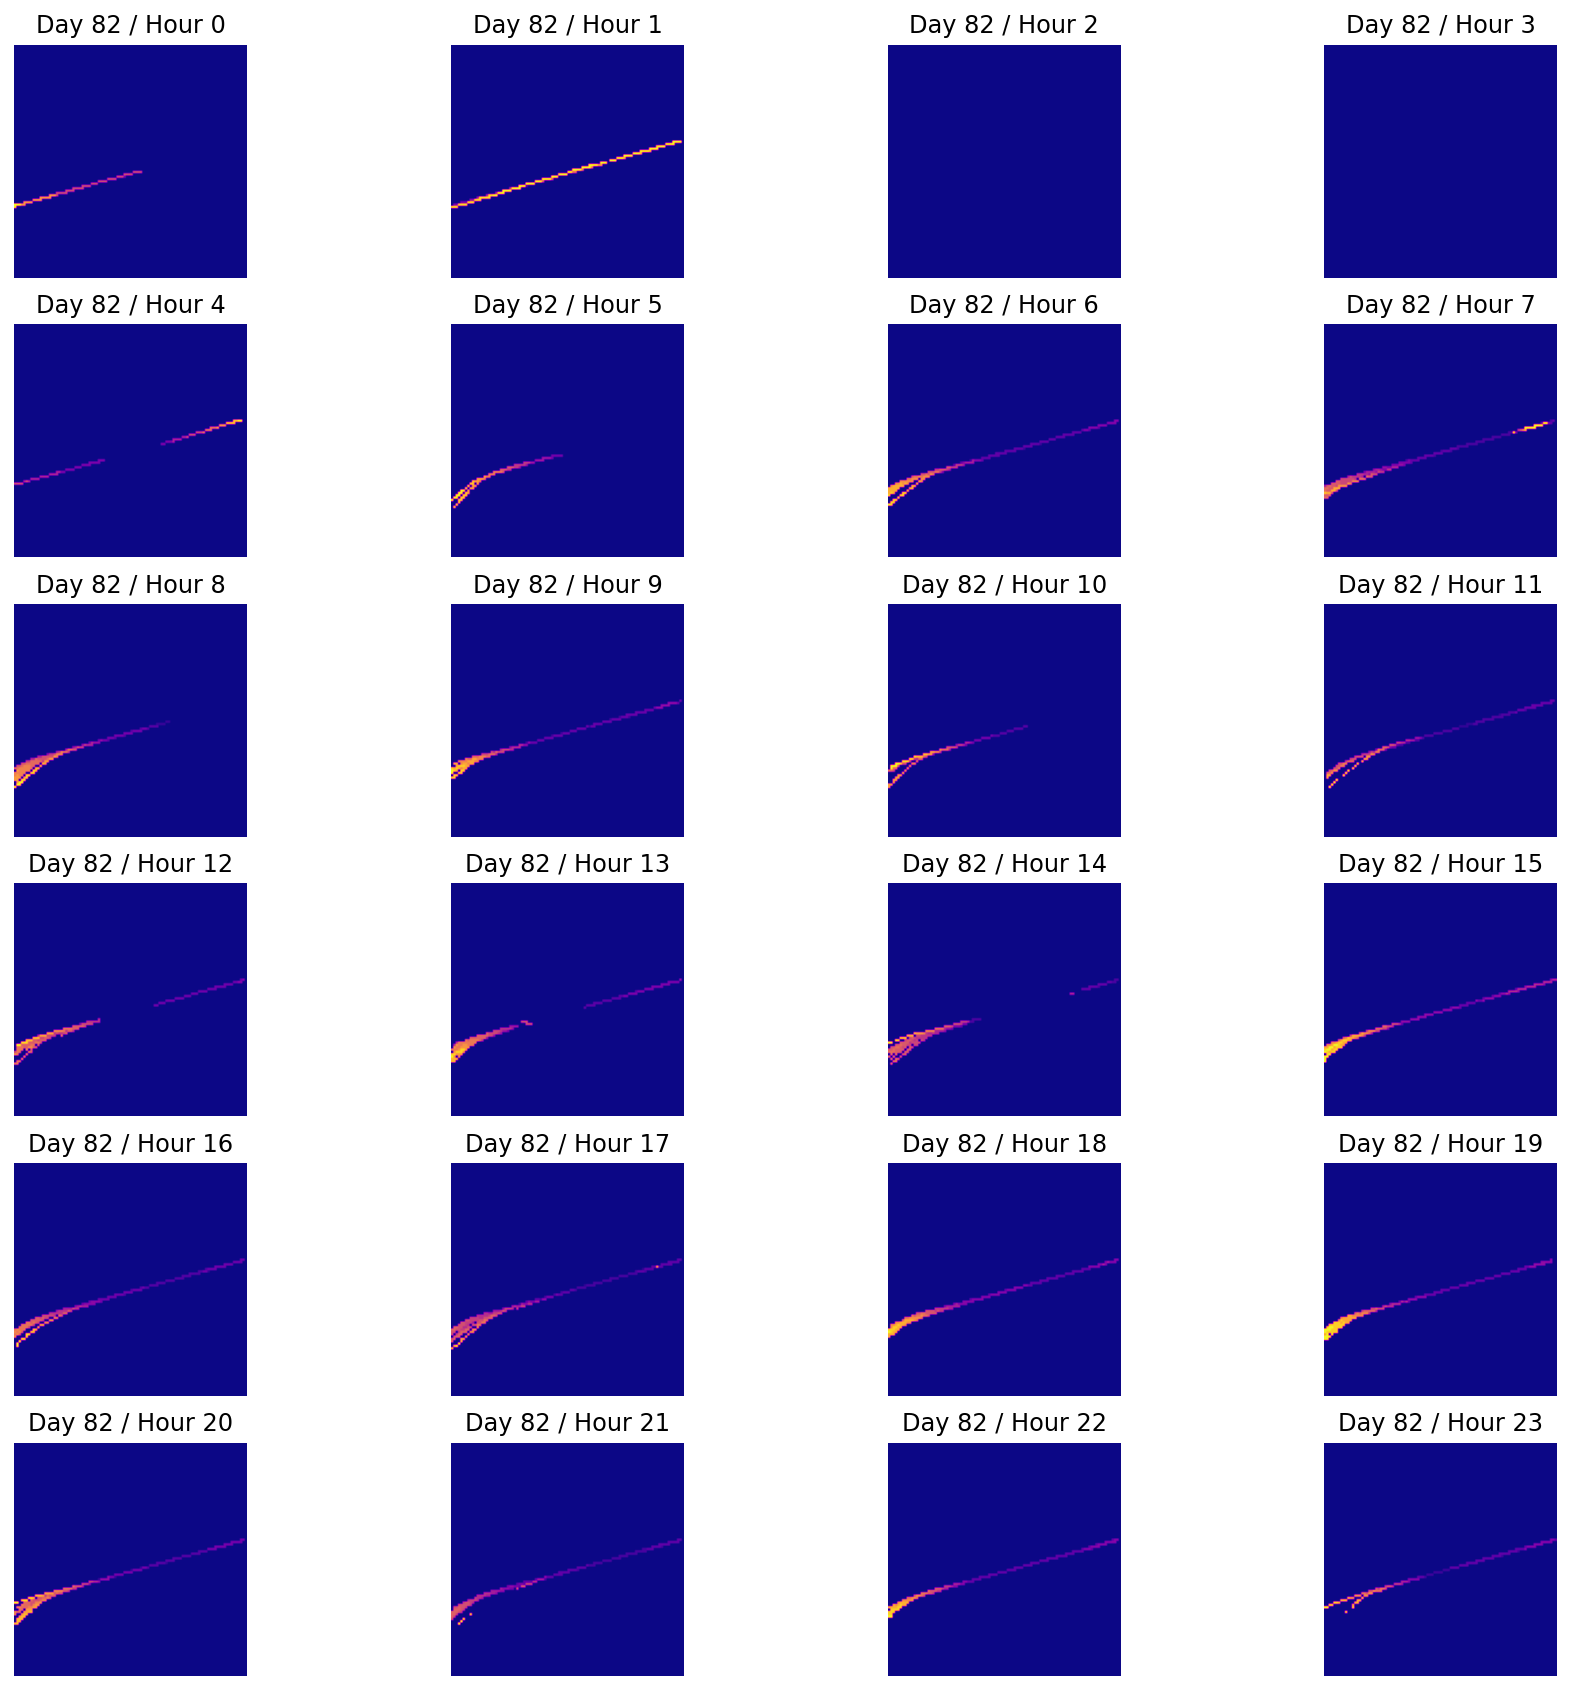

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

day = 82

# Previews a whole day
fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(masked_day_array[day, idx]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'Day {day} / Hour {idx}')
  ax.axis("off")

# Save Results

**Save Average Flights Array**

In [ ]:
np.save(f'dataset/00_results/flights_average_{masked_day_array.shape[0]}.npy', flights_average)

**Save Masked Array**

In [ ]:
np.save(f'dataset/00_results/flights_array_masked_{masked_day_array.shape[0]}.npy', masked_day_array)